<span style="font-size: 36px;">Task 2.1</span>

      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...          20247395.0          19111729.0   

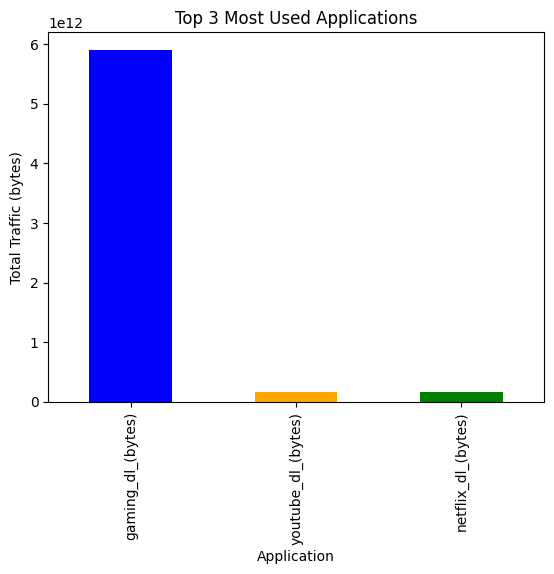

Top 10 Engaged Users per Application:
 {'social_media_dl_(bytes)':        msisdn/number  social_media_dl_(bytes)  email_dl_(bytes)  \
4947    3.366258e+10               15856187.0        12504906.0   
6265    3.366552e+10               14192876.0        14007755.0   
10747   3.376387e+10               13343848.0        10474225.0   
6638    3.366642e+10               13171166.0        11242938.0   
2276    3.365813e+10               13086304.0        15574842.0   
10577   3.376354e+10               12940091.0         9610340.0   
6293    3.366555e+10               12936053.0         6709102.0   
6048    3.366518e+10               12248222.0        10410127.0   
4536    3.366182e+10               12010152.0         5899426.0   
1782    3.365054e+10               11703732.0         9081581.0   

       youtube_dl_(bytes)  netflix_dl_(bytes)  gaming_dl_(bytes)  
4947           42824644.0          91301512.0       3.285899e+09  
6265           77210030.0          81450750.0       2.155579e

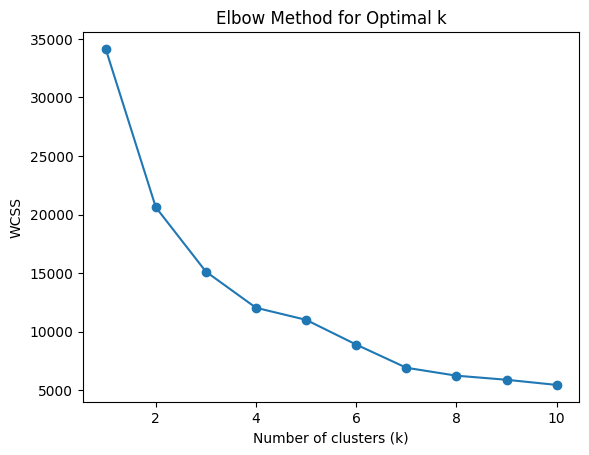

In [4]:
import sys
import os
from sklearn.preprocessing import StandardScaler

sys.path.insert(0, os.path.abspath(r'C:/Users/User/Desktop/Week-2/scripts'))

from UserEngagementAnalysis import (
    clean_and_prepare_data, 
    process_engagement_data, 
    analyze_top_customers, 
    perform_clustering,
    visualize_app_traffic,
    plot_elbow_method
    )

input_file_path = 'C:/Users/User/Desktop/10/data-2/Week2_challenge_data_source(CSV).csv'

# Step 1: Clean and prepare data
df = clean_and_prepare_data(input_file_path)

# Step 2: Process engagement data
engagement_df = process_engagement_data(df)

# Step 3: Analyze top customers
top_10_sessions_frequency, top_10_session_duration, top_10_total_traffic = analyze_top_customers(engagement_df)
print("Top 10 Customers by Sessions Frequency:\n", top_10_sessions_frequency)
print("Top 10 Customers by Session Duration:\n", top_10_session_duration)
print("Top 10 Customers by Total Traffic:\n", top_10_total_traffic)

# Step 4: Perform clustering
engagement_df, cluster_stats = perform_clustering(engagement_df)
print("Cluster Statistics:\n", cluster_stats)

# Step 5: Visualize app traffic
top_10_app_traffic = visualize_app_traffic(df)
print("Top 10 Engaged Users per Application:\n", top_10_app_traffic)

# Step 6: Plot elbow method for clustering
features = ['sessions_frequency', 'session_duration', 'total_traffic']
scaler = StandardScaler()
engagement_df_scaled = scaler.fit_transform(engagement_df[features])
plot_elbow_method(engagement_df_scaled)
